In [1]:
import numpy as np
import pandas as pd
import cv2
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [6]:
import zipfile
import os

zip_file_path = '/content/bonefracture_data.zip'
extracted_dir_path = '/content/extracted'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_path)
    print("Extraction completed.")
except zipfile.BadZipFile:
    print("Error: The provided file is not a valid zip file.")
except Exception as e:
    print("An error occurred during extraction:", str(e))


Extraction completed.


In [7]:
# Define paths to train, test, and validation data
train_data_dir = "/content/extracted/archive (6)/train"
test_data_dir = "/content/extracted/archive (6)/test"
val_data_dir = "/content/extracted/archive (6)/val"


In [8]:
img_width, img_height = 150, 150
batch_size = 32


In [9]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


In [10]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [13]:
from keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/25
276/276 [==============================] - 475s 2s/step - loss: 0.6524 - accuracy: 0.6101 - val_loss: 0.6100 - val_accuracy: 0.5226
Epoch 2/25
276/276 [==============================] - 478s 2s/step - loss: 0.6443 - accuracy: 0.6154 - val_loss: 0.5740 - val_accuracy: 0.6354
Epoch 3/25
276/276 [==============================] - 464s 2s/step - loss: 0.6309 - accuracy: 0.6311 - val_loss: 0.6040 - val_accuracy: 0.6528
Epoch 4/25
276/276 [==============================] - 466s 2s/step - loss: 0.6167 - accuracy: 0.6464 - val_loss: 0.6141 - val_accuracy: 0.5260
Epoch 5/25
276/276 [==============================] - 461s 2s/step - loss: 0.6113 - accuracy: 0.6528 - val_loss: 0.6775 - val_accuracy: 0.5156


In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/25
276/276 [==============================] - 468s 2s/step - loss: 0.6242 - accuracy: 0.6347 - val_loss: 0.6276 - val_accuracy: 0.6458
Epoch 2/25
276/276 [==============================] - 467s 2s/step - loss: 0.6175 - accuracy: 0.6495 - val_loss: 0.5578 - val_accuracy: 0.5608
Epoch 3/25
276/276 [==============================] - 464s 2s/step - loss: 0.6086 - accuracy: 0.6664 - val_loss: 0.6201 - val_accuracy: 0.5903
Epoch 4/25
276/276 [==============================] - 464s 2s/step - loss: 0.5954 - accuracy: 0.6716 - val_loss: 0.5668 - val_accuracy: 0.6753
Epoch 5/25
276/276 [==============================] - 465s 2s/step - loss: 0.5789 - accuracy: 0.6854 - val_loss: 0.6744 - val_accuracy: 0.5226


TEST DATASET


/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/test/fractured/2.jpg
1/1 [==============================] - 0s 117ms/step


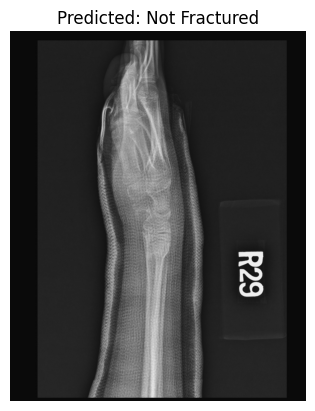

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)


/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/test/not fractured/16-rotated2-rotated3-rotated2.jpg
1/1 [==============================] - 0s 54ms/step


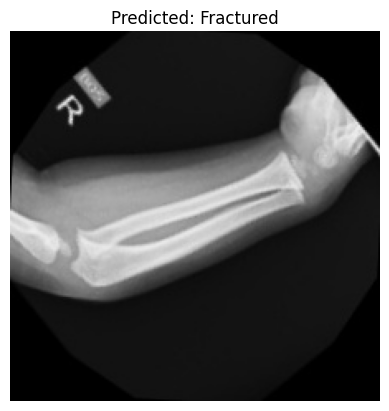

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)

TRAIN DATASET

/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/train/fractured/10-rotated2-rotated2-rotated1.jpg
1/1 [==============================] - 0s 37ms/step


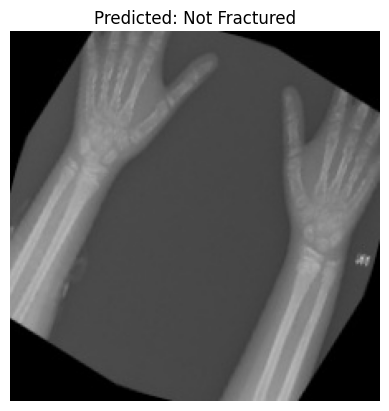

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)

/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/train/not fractured/10-rotated2-rotated2-rotated1.jpg
1/1 [==============================] - 0s 35ms/step


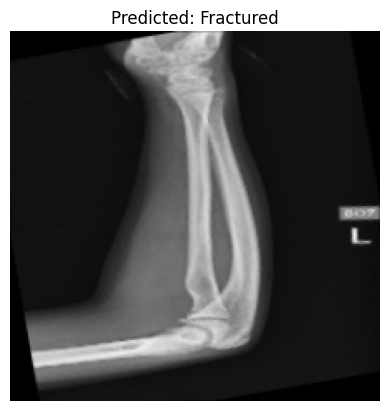

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)

VAL DATASET

/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/val/fractured/1-rotated1-rotated1-rotated1.jpg
1/1 [==============================] - 0s 34ms/step


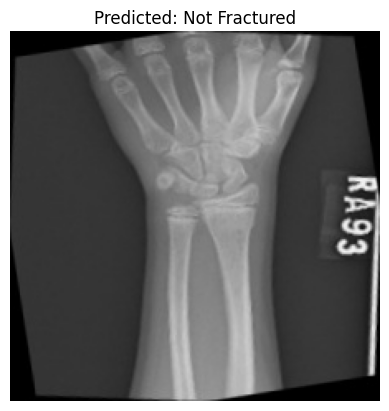

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)

/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg /content/extracted/archive (6)/val/not fractured/1-rotated1-rotated2-rotated1.jpg
1/1 [==============================] - 0s 48ms/step


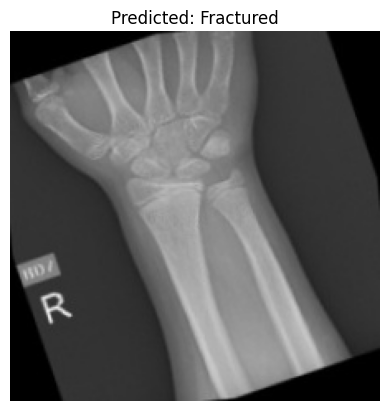

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values
    return img_array

# Function to predict and plot the result
def predict_and_plot(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = "Fractured" if prediction[0][0] > 0.5 else "Not Fractured"

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# User input for image path
image_path = input("/content/bone_set/archive (6)/test/not fractured/1-rotated2-rotated2-rotated2-rotated1.jpg ")

# Predict and plot the result
predict_and_plot(image_path, model)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 75, 75, 64)       

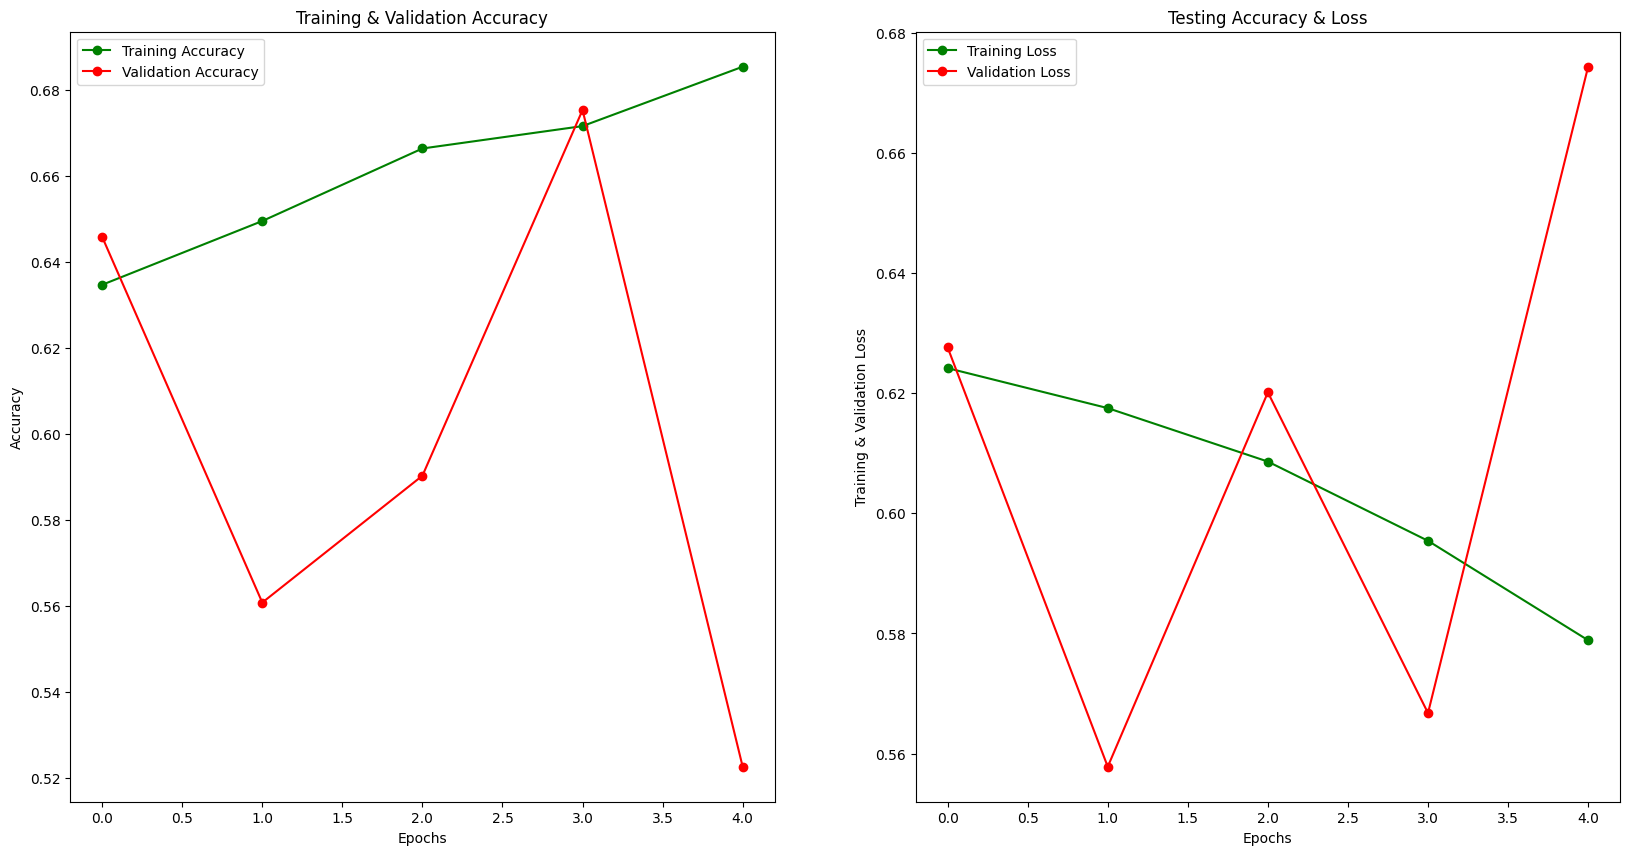

In [40]:
epochs = [i for i in range(len(history.history['accuracy']))]  # Adjust epochs according to the actual number of epochs trained
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()